In [196]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [197]:
import os
import torch

import torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader

%run visualize.py
from visualize import GraphVisualization 
import plotly

import networkx as nx
from networkx.algorithms import community


dataset = TUDataset(root='dataset/Mutag', name='MUTAG')

<Figure size 640x480 with 0 Axes>

In [198]:
data_details = {
    "num_node_features": dataset.num_node_features,
    "num_edge_features": dataset.num_edge_features,
    "num_classes": dataset.num_classes,
    "num_node_labels": dataset.num_node_labels,
    "num_edge_labels": dataset.num_edge_labels
}

print(data_details)

{'num_node_features': 7, 'num_edge_features': 4, 'num_classes': 2, 'num_node_labels': 7, 'num_edge_labels': 4}


In [199]:
def create_graph(graph):
    g = to_networkx(graph)
    pos = nx.spring_layout(g)
    vis = GraphVisualization(
        g, pos, node_text_position='top left', node_size=20,
    )
    fig = vis.create_figure()
    return fig

fig = create_graph(dataset[0])
fig.show()

In [200]:
# Defining the loaders

torch.manual_seed(12345)
dataset = dataset.shuffle()
train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(len(train_dataset))
print(len(test_dataset))

train_loader = DataLoader(dataset=dataset, batch_size = 64, shuffle=True)
test_loader = DataLoader(dataset=dataset, batch_size = 1, shuffle=False)

150
38


In [201]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)

In [202]:
model = GCN(hidden_channels=64)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.CrossEntropyLoss()

losses, accuracies = [], []
def train():
    model.train()
    for data in train_loader: # Iterates the batches. We declared each batch to be of size 64.
        out = model(data.x, data.edge_index, data.batch)

        cat = torch.argmax(out, dim=1)
        accuracy = (cat == data.y).float().mean()
        accuracies.append(accuracy.item())



        loss = loss_function(out, data.y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()




    


100%|██████████| 170/170 [00:05<00:00, 32.79it/s]


AttributeError: 'list' object has no attribute 'last'

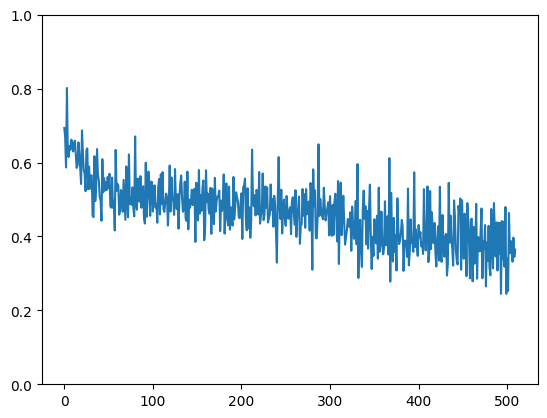

In [203]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
for epoch in trange(1, 171):
    train()
    #test(train_loader)

ylim(0, 1)

plot(losses)

plot(accuracies)

line1, = plot(losses, label="Loss")
line1, = plot(accuracies, label="Accuracy")

leg = plt.legend(loc='lower center')